<a href="https://colab.research.google.com/github/d9249/MDL/blob/main/KLGrade_DenseNet121-91.83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10662605877982022121
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22727688192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18086061693943596665
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [2]:
!nvidia-smi

Wed Nov  3 16:30:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090   WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   44C    P2    37W / 350W |    599MiB / 24576MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Short description
This notebook is a part of [Data Sprint #35: Osteoarthritis Knee X-ray](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/leaderboard/datathon/) challenge hosted on [dphi.tech](https://dphi.tech/)

## Importing dependencies

## 종속성을 가져오는 중 

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

# Basic Idea
The Basic idea is to use external data present in kaggle here: [Kaggle: Knee Osteoarthritis Dataset with KL Grading - 2018](https://www.kaggle.com/tommyngx/kneeoa)

As we have labels for train, validation and test, we will combine all splits into one and test it on dataset provided by the compitition team, this will make sure kaggle dataset and compitition dataset has same data distribution.

If train(kaggle dataset) and test (compition dataset) data has same distribution then their metric score should be roughy be the same (accuracy score in our case).

# 기본 아이디어
기본 아이디어는 여기 카글에 있는 외부 데이터를 사용하는 것이다. [Kaggle: KL Grading이 있는 무릎 골관절염 데이터 세트 - 2018](https://www.kaggle.com/tommyngx/kneeoa)

교육, 검증 및 테스트를 위한 레이블이 있으므로 모든 분할을 하나로 결합하고 구성 팀에서 제공하는 데이터 세트에서 테스트합니다. 이렇게 하면 Kaggle 데이터 세트와 구성 데이터 세트가 동일한 데이터 분포를 갖출 수 있습니다.

열차(카글 데이터 세트)와 테스트(컴포지션 데이터 세트) 데이터의 분포가 동일하면 메트릭 점수가 대략 같아야 한다(우리의 경우 정확도 점수).

# Read And Combining train dataset (kaggle dataset)

# 열차 데이터 세트 읽기 및 결합 (Kaggle 데이터 세트)

In [4]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "C:\\Users\\ngkim\\Downloads\\ClsKLData\\kneeKL224\\"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [5]:
df_train_kaggle.shape

(9786, 2)

### Observation
we have total of 9786 images in kaggle dataset. We will use data to train the deep learning model
# Lets look at class distribution

## 관찰
우리는 카글 데이터 세트에 총 9786개의 이미지를 가지고 있다. 우리는 딥 러닝 모델을 훈련시키기 위해 데이터를 사용할 것이다.
# 학급분포를 살펴보자

Text(0, 0.5, 'count')

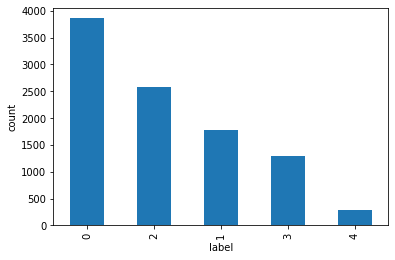

In [6]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

### Observation
As our dataset is imbalanced, we will balance our class by weighting majority class less and minoiry class more

## 관찰
데이터 세트가 불균형적이므로 다수 클래스는 덜 가중치 부여하고 소수 클래스는 더 가중치를 부여하여 클래스 균형을 맞출 것이다.

## DataGenerator train and validation
We will use kaggle dataset as train set and compitition dataset as validation set. If train and validation metric is similar, it shows their distribution is similar and hence we can use kaggle dataset as well.

# 데이터 생성기 교육 및 검증
우리는 캐글 데이터 세트를 열차 세트로, 컴포지션 데이터 세트를 검증 세트로 사용할 것이다. 열차와 검증 메트릭이 유사한 경우 분포가 유사함을 보여주므로 캐글 데이터 세트도 사용할 수 있다.

In [7]:
# train data generator object
train_aug = ImageDataGenerator(
    rescale = 1./255
  )

# validation data generator object
valid_aug = ImageDataGenerator(
    rescale = 1./255
  )

In [8]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
    dataframe = df_train_kaggle,
    directory = None,
    x_col = "filepath",
    y_col = "label",
    batch_size = 16,
    seed = 42,
    shuffle = True,
    class_mode = "raw",
    target_size = (224,224)
  )

Found 9786 validated image filenames.


# Create validation dataframe using compitition dataset.
We will download compition dataset from gdrive and use it as validation set to validated against kaggle dataset

# composition dataset을 이용하여 검증 데이터 프레임을 생성합니다.
gdrive에서 컴포지션 데이터 세트를 다운로드하여 Kaggle 데이터 세트에 대해 검증된 검증 세트로 사용할 것입니다.

In [9]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path = "C:\\Users\\ngkim\\Downloads\\KneeXray\\"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,0
1,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,1
2,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,0
3,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,1
4,C:\Users\ngkim\Downloads\KneeXray\train/Image_...,2


Text(0, 0.5, 'count')

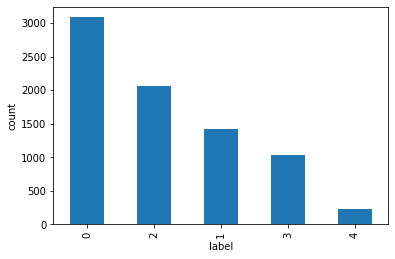

In [10]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [11]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
    dataframe = df_val_compi,
    x_col = "filename",
    y_col = "label",
    batch_size = 16,
    seed = 42,
    shuffle= True,
    class_mode = "raw",
    target_size = (224,224)
  )

Found 7828 validated image filenames.


### Model Architecture
Here we will be using Xception by google. (I encourage you to try different architectures)

## 모델 아키텍처
여기서는 구글의 Xception을 사용할 것입니다. (다양한 아키텍처를 사용해 보십시오)

## CheXNet - DenseNet121 + Sigmoid
https://github.com/arnoweng/CheXNet/blob/master/model.py

In [12]:
from tensorflow.keras.applications import DenseNet121

xception = Xception(weights = "imagenet",)
x =  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters = 1024, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = n_class, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs = pred)

In [13]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
# compile
xception_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, decay = 0.0001),
    metrics = ["acc"],
    loss = tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
              ModelCheckpoint(
                   checkpoint_path,
                   monitor = 'val_acc',
                   verbose = 1,
                   save_weights_only = True,
                   save_best_only = True,
                   mode = "max"
                  ),
              EarlyStopping(
                   monitor = 'val_loss',
                   patience = 10,
                   verbose = 0
                  ),
              ReduceLROnPlateau(
                   monitor = 'val_loss',
                   patience = 10,
                   verbose = 1
                  )
]

### Weighting classes
As we have unevenly class distibution, we will weight them based on the number of samples

### 가중치 클래스
우리는 등급 차이가 일정하지 않기 때문에 샘플 수에 따라 무게를 재도록 하겠습니다.

In [15]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(df_train_kaggle.label.values),
    y = df_train_kaggle.label.values
  )

class_weights = dict(enumerate(class_weights))

# Train
Lets roll

In [16]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2372203962267327224
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22727688192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16673566931728661802
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [18]:
# train the model
xception_model.fit(
        train_generator,
        epochs = 300,
        validation_data = valid_generator,
        callbacks = [my_callbacks],
        class_weight = class_weights
      )

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/300
612/612 [==============================] - 93s 144ms/step - loss: 1.4003 - acc: 0.3257 - val_loss: 1.5241 - val_acc: 0.3604

Epoch 00001: val_acc improved from -inf to 0.36037, saving model to xception_best.ckpt
Epoch 2/300
612/612 [==============================] - 87s 142ms/step - loss: 1.1781 - acc: 0.4745 - val_loss: 1.2709 - val_acc: 0.5446

Epoch 00002: val_acc improved from 0.36037 to 0.54458, saving model to xception_best.ckpt
Epoch 3/300
612/612 [==============================] - 87s 141ms/step - loss: 1.0648 - acc: 0.5461 - val_loss: 1.2430 - val_acc: 0.5583

Epoch 00003: val_acc improved from 0.54458 to 0.55825, saving model to xception_best.ckpt
Epoch 4/300
612/612 [==============================] - 87s 141ms/step - loss: 0.9764 - acc: 0.6022 - val_loss: 1.1287 - val_acc: 0.6385

Epoch 00004: val_acc improved from 0.55825 to 0.63848, saving model to xception_best.ckpt
Epoch 5/300
612/612 [==============================] - 87s 142ms/step - loss: 0.8960 - acc: 0.6


Epoch 00039: val_acc improved from 0.96653 to 0.96909, saving model to xception_best.ckpt
Epoch 40/300
612/612 [==============================] - 87s 142ms/step - loss: 0.4391 - acc: 0.9847 - val_loss: 0.5649 - val_acc: 0.9612

Epoch 00040: val_acc did not improve from 0.96909
Epoch 41/300
612/612 [==============================] - 86s 141ms/step - loss: 0.4355 - acc: 0.9849 - val_loss: 0.5657 - val_acc: 0.9656

Epoch 00041: val_acc did not improve from 0.96909
Epoch 42/300
612/612 [==============================] - 86s 141ms/step - loss: 0.4366 - acc: 0.9848 - val_loss: 0.5664 - val_acc: 0.9633

Epoch 00042: val_acc did not improve from 0.96909
Epoch 43/300
612/612 [==============================] - 87s 142ms/step - loss: 0.4337 - acc: 0.9846 - val_loss: 0.5633 - val_acc: 0.9650

Epoch 00043: val_acc did not improve from 0.96909
Epoch 44/300
612/612 [==============================] - 86s 141ms/step - loss: 0.4342 - acc: 0.9852 - val_loss: 0.5695 - val_acc: 0.9595

Epoch 00044: val_ac

612/612 [==============================] - 86s 141ms/step - loss: 0.3911 - acc: 0.9937 - val_loss: 0.4987 - val_acc: 0.9716

Epoch 00082: val_acc did not improve from 0.97739
Epoch 83/300
612/612 [==============================] - 86s 141ms/step - loss: 0.3932 - acc: 0.9953 - val_loss: 0.4963 - val_acc: 0.9738

Epoch 00083: val_acc did not improve from 0.97739
Epoch 84/300
612/612 [==============================] - 87s 141ms/step - loss: 0.3954 - acc: 0.9927 - val_loss: 0.4981 - val_acc: 0.9695

Epoch 00084: val_acc did not improve from 0.97739
Epoch 85/300
612/612 [==============================] - 86s 141ms/step - loss: 0.3881 - acc: 0.9943 - val_loss: 0.4949 - val_acc: 0.9730

Epoch 00085: val_acc did not improve from 0.97739
Epoch 86/300
612/612 [==============================] - 87s 142ms/step - loss: 0.3895 - acc: 0.9928 - val_loss: 0.4877 - val_acc: 0.9762

Epoch 00086: val_acc did not improve from 0.97739
Epoch 87/300
612/612 [==============================] - 87s 142ms/step - 


Epoch 00124: val_acc did not improve from 0.98275
Epoch 125/300
612/612 [==============================] - 86s 141ms/step - loss: 0.3679 - acc: 0.9969 - val_loss: 0.4565 - val_acc: 0.9793

Epoch 00125: val_acc did not improve from 0.98275
Epoch 126/300
612/612 [==============================] - 86s 141ms/step - loss: 0.3643 - acc: 0.9968 - val_loss: 0.4554 - val_acc: 0.9801

Epoch 00126: val_acc did not improve from 0.98275
Epoch 127/300
612/612 [==============================] - 87s 143ms/step - loss: 0.3650 - acc: 0.9967 - val_loss: 0.4567 - val_acc: 0.9784

Epoch 00127: val_acc did not improve from 0.98275
Epoch 128/300
612/612 [==============================] - 87s 142ms/step - loss: 0.3629 - acc: 0.9973 - val_loss: 0.4551 - val_acc: 0.9802

Epoch 00128: val_acc did not improve from 0.98275
Epoch 129/300
612/612 [==============================] - 88s 143ms/step - loss: 0.3675 - acc: 0.9955 - val_loss: 0.4549 - val_acc: 0.9793

Epoch 00129: val_acc did not improve from 0.98275
Epoc

612/612 [==============================] - 87s 142ms/step - loss: 0.3500 - acc: 0.9981 - val_loss: 0.4272 - val_acc: 0.9805

Epoch 00168: val_acc did not improve from 0.98429
Epoch 169/300
612/612 [==============================] - 87s 142ms/step - loss: 0.3472 - acc: 0.9973 - val_loss: 0.4327 - val_acc: 0.9794

Epoch 00169: val_acc did not improve from 0.98429
Epoch 170/300
612/612 [==============================] - 87s 141ms/step - loss: 0.3536 - acc: 0.9974 - val_loss: 0.4346 - val_acc: 0.9805

Epoch 00170: val_acc did not improve from 0.98429
Epoch 171/300
612/612 [==============================] - 87s 142ms/step - loss: 0.3507 - acc: 0.9980 - val_loss: 0.4284 - val_acc: 0.9825

Epoch 00171: val_acc did not improve from 0.98429
Epoch 172/300
612/612 [==============================] - 87s 142ms/step - loss: 0.3482 - acc: 0.9978 - val_loss: 0.4313 - val_acc: 0.9801

Epoch 00172: val_acc did not improve from 0.98429
Epoch 173/300
612/612 [==============================] - 87s 142ms/st

### Observation
As we can see train and validation accuracy is pretty close, which proves kaggle and competition data has come from the same distribution and we can freely use it to experiment with.

## Retraining last trained model on competition data
As we have used competition data as validation set previously, we will use it as train set now (and some part of it as validation set) hoping this additional training would give our model new information to perform better.

## 관찰
보시다시피 열차와 검증 정확도는 매우 가까우며, 이는 카글과 경쟁 데이터가 동일한 분포에서 나왔다는 것을 증명하며, 이를 실험하는 데 자유롭게 사용할 수 있습니다.

## 경기 데이터에 대해 마지막으로 훈련된 모델 재교육
이전에 경쟁 데이터를 검증 세트로 사용했으므로, 이제 열차 세트로 사용할 것이며(그리고 그 중 일부는 검증 세트로) 이 추가 교육을 통해 모델이 더 나은 성능을 발휘할 수 있는 새로운 정보를 얻을 수 있기를 바랍니다.

In [19]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(
    df_val_compi,
    test_size = 0.1,
    random_state = 42,
    stratify = df_val_compi.label
  )

In [20]:
train_generator = train_aug.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filename",
    y_col = "label",
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "raw",
    target_size = (224,224)
  )

Found 7045 validated image filenames.


In [21]:
valid_generator = valid_aug.flow_from_dataframe( 
    dataframe = X_test,
    x_col = "filename",
    y_col = "label",
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "raw",
    target_size = (224,224)
  )

Found 783 validated image filenames.


In [22]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [23]:
# kick off training
xception_model.fit(
        train_generator,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = 50,
        validation_data = valid_generator,
        validation_steps = STEP_SIZE_VALID,callbacks = [my_callbacks]
      )

Epoch 1/50
220/220 [==============================] - 52s 228ms/step - loss: 0.4377 - acc: 0.9835 - val_loss: 0.3719 - val_acc: 0.9974

Epoch 00001: val_acc improved from 0.98505 to 0.99740, saving model to xception_best.ckpt
Epoch 2/50
220/220 [==============================] - 50s 225ms/step - loss: 0.4317 - acc: 0.9847 - val_loss: 0.3680 - val_acc: 0.9987

Epoch 00002: val_acc improved from 0.99740 to 0.99870, saving model to xception_best.ckpt
Epoch 3/50
220/220 [==============================] - 50s 225ms/step - loss: 0.4168 - acc: 0.9903 - val_loss: 0.3697 - val_acc: 0.9961

Epoch 00003: val_acc did not improve from 0.99870
Epoch 4/50
220/220 [==============================] - 49s 224ms/step - loss: 0.4153 - acc: 0.9934 - val_loss: 0.3665 - val_acc: 0.9987

Epoch 00004: val_acc did not improve from 0.99870
Epoch 5/50
220/220 [==============================] - 50s 227ms/step - loss: 0.4139 - acc: 0.9930 - val_loss: 0.3646 - val_acc: 0.9987

Epoch 00005: val_acc did not improve fro

In [24]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

# Confusion Matrix
As our data set is imbalaned, lets see where is our model making mistakes. I encourage to you to take initative for bringing FPs and FNs down.

# 혼란 매트릭스
데이터 세트가 불균형 상태이므로 모델이 어디에서 실수를 하는지 살펴보자. FP와 FN을 끌어내리는데 솔선수범하길 바랍니다.

In [25]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filename",
    class_mode = None,
    target_size = (target_shape, target_shape),
    shuffle = False,
    batch_size = BATCH_SIZE
  )

Found 783 validated image filenames.


In [26]:
# prediction on train data
predicition_compi = xception_model.predict(compi_gen, steps = compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 5s 6ms/step


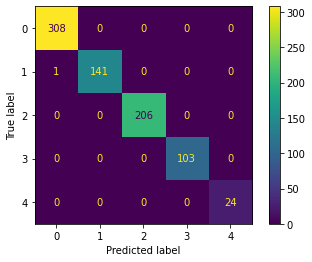

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_prediction_compi = np.argmax(predicition_compi, axis = 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels = [0, 1, 2, 3, 4])

disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [0, 1, 2, 3, 4]
  )

disp.plot()

## Making prediction on test set (to make submission)
Finally we save the predictions on disk in CSV format

## 시험세트 예측하기 (제출하기)
마지막으로 예측 내용을 CSV 형식으로 디스크에 저장합니다.

In [28]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
    dataframe = test,
    directory = compi_root_path + "test",
    x_col = "filename",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224,224)
  )

# number of steps to consider 1 epoch
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [29]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 12s 6ms/step


0    766
2    523
1    353
3    257
4     59
Name: label, dtype: int64

### Clearing the working directory
Because if don't, "output" tabl will show only images

### 작업 디렉토리 지우기
그렇지 않으면 "출력" 탭이 이미지만 표시되기 때문입니다.

In [30]:
import sys
import shutil

# Get directory name
mydir = "/kaggle/working"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working - 지정된 경로를 찾을 수 없습니다.


### Save best weights and output prediction file

### 최적의 가중치 및 출력 예측 파일 저장

In [31]:
xception_model.save_weights("knee_xray_Xceptionnet_GPA.h5")
df_submit.to_csv("submission.csv",index = False)

The submission results in 96.8% on public leaderboard.

**Suggestion to improve the score**
* Using right data augmentations
* Using different model architecture
* Ensembling and stacking
* Using pretrained model trained on xray images

제출 결과 공개 리더보드에서 96.8%의 결과가 나왔습니다.

**점수 향상을 위한 제안*
* 올바른 데이터 확대 사용
* 다른 모델 아키텍처 사용
* 조립 및 쌓기
* X선 영상에 대해 사전 훈련된 모델 사용